In [1]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

from imblearn.over_sampling import RandomOverSampler

In [3]:
path = "../Data/Data_ECB_small.csv"

df = pd.read_csv(path)
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables


In [4]:
df["user_id"].nunique()

9401

In [493]:
df.fillna(0, inplace=True)

In [577]:
df_model = pd.DataFrame()
df_model["target"] = pd.qcut(x=df.groupby("user_id")["user_id"].count(), q=2, labels=["low", "high"])

In [17]:
df["num_purchases"] = df["user_id"].map(df.iloc[df["order_id"].drop_duplicates().index]["user_id"].value_counts())

In [38]:
df

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name,num_purchases
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients,1
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree,1
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter,1
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables,1
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2349966,177470,40,4,9,1.0,11,8,0,11,personal care,cold flu allergy,1
99996,2349966,177470,40,4,9,1.0,99,9,0,15,canned goods,canned fruit applesauce,1
99997,2349966,177470,40,4,9,1.0,17,10,0,13,pantry,baking ingredients,1
99998,2276450,88833,20,2,18,5.0,37,1,1,1,frozen,ice cream ice,1


In [19]:
df["num_purchases"].value_counts()

num_purchases
1    91340
2     7976
3      640
4       44
Name: count, dtype: int64

In [43]:
df[["order_id","user_id", "num_purchases"]].set_index("order_id").drop_duplicates()

,user_id,num_purchases
order_id,,
2425083,49125,1
1944304,162867,1
1201011,147243,2
1906860,195275,1
2766469,58222,1
...,...,...
1955799,161873,1
1794066,157283,1
2349966,177470,1


In [44]:
df_model = pd.DataFrame()
df_model["num_purchases"] = df[["order_id","user_id", "num_purchases"]].set_index("order_id").drop_duplicates()["num_purchases"].copy()

In [23]:
list_user_id = sorted(df["user_id"].unique())

In [579]:
df.groupby("user_id")["product_name"].value_counts()

user_id  product_name              
2        fresh fruits                  3
         packaged cheese               2
         chips pretzels                1
         crackers                      1
         fresh dips tapenades          1
                                      ..
206209   milk                          1
         packaged vegetables fruits    1
         spices seasonings             1
         trash bags liners             1
         yogurt                        1
Name: product_name, Length: 1109568, dtype: int64

In [46]:
g_product = df.groupby("user_id")["product_name"].value_counts(ascending=False)
g_department = df.groupby("user_id")["department"].value_counts(ascending=False)

g_max_days = (df.groupby(["user_id","order_id"])["days_since_prior_order"].sum()/df.groupby(["user_id","order_id"])["days_since_prior_order"].count())

In [47]:
product_bought_1 = [g_product[x].index[0] for x in list_user_id]
department_bought_1 = [g_department[x].index[0] for x in list_user_id]

In [48]:
df_model["product_1"] = product_bought_1
df_model["department_1"] = department_bought_1
df_model["days_since_started"] = g_max_days.reset_index().groupby("user_id")["days_since_prior_order"].sum().values

In [381]:
df.groupby("user_id")["user_id"].count()

user_id
37         4
38        14
56         9
75        16
77        18
          ..
206042     3
206105     4
206127     3
206156     4
206206     1
Name: user_id, Length: 9401, dtype: int64

In [49]:
df_model

,num_purchases,product_1,department_1,days_since_started
order_id,,,,
2425083,1,spreads,produce,15.0
1944304,1,packaged cheese,dairy eggs,30.0
1201011,2,nuts seeds dried fruit,snacks,0.0
1906860,1,fresh vegetables,produce,9.0
2766469,1,fresh vegetables,produce,5.0
...,...,...,...,...
1955799,1,packaged produce,produce,0.0
1794066,1,frozen appetizers sides,frozen,0.0
2349966,1,energy sports drinks,beverages,30.0


In [71]:
y = df_model[["num_purchases"]]

In [51]:
#Enc = OneHotEncoder()
#y_enc = Enc.fit_transform(y)
#y_new = y_enc.toarray()

In [72]:
X = df_model.drop("num_purchases", axis=1)

Enc = OneHotEncoder()
X_enc = Enc.fit_transform(X.drop("days_since_started", axis=1))
X_new = pd.DataFrame(X_enc.toarray())
X_new[X_new.shape[1]] = df_model["days_since_started"].values

In [73]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

X_ros, y_ros = ros.fit_resample(X_new, y)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

In [103]:
clf = MLPClassifier(random_state=42, max_iter=200, hidden_layer_sizes=10, learning_rate_init=0.001, activation="tanh")
model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [104]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.7973052954078613
0.7870770087731513


In [105]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.76      0.56      0.64      1825
           2       0.72      0.69      0.71      1770
           3       0.73      0.90      0.81      1762
           4       0.92      1.00      0.96      1824

    accuracy                           0.79      7181
   macro avg       0.78      0.79      0.78      7181
weighted avg       0.78      0.79      0.78      7181



In [593]:
clf.predict_proba(X_test)

array([[0.60171768, 0.39828217],
       [0.10850052, 0.89150315],
       [0.16595801, 0.8340462 ],
       ...,
       [0.60979118, 0.39020855],
       [0.52969907, 0.4703019 ],
       [0.45367571, 0.5463264 ]])

In [594]:
y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [563]:
clf.predict_proba(X_test)[:,0]

array([0.4446725 , 0.05468029, 0.09295035, ..., 0.44064354, 0.273177  ,
       0.24800202])

In [622]:
report_2 = classification_report(y_test, y_pred)
print(report_2)

              precision    recall  f1-score   support

           0       0.67      0.68      0.68      5043
           1       0.70      0.69      0.70      5485

   micro avg       0.69      0.69      0.69     10528
   macro avg       0.69      0.69      0.69     10528
weighted avg       0.69      0.69      0.69     10528
 samples avg       0.69      0.69      0.69     10528



In [607]:
precision_0, recall_0, threshold_0 = precision_recall_curve(y_test[:,0], clf.predict_proba(X_test)[:,0])
precision_1, recall_1, threshold_1 = precision_recall_curve(y_test[:,1], clf.predict_proba(X_test)[:,1])

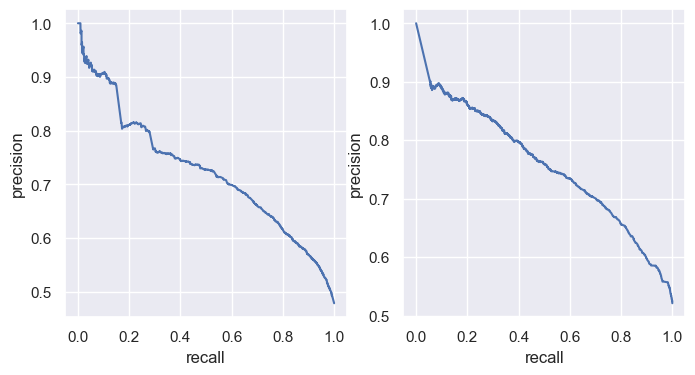

In [623]:
_, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].plot(recall_0, precision_0)
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")


ax[1].plot(recall_1, precision_1)
ax[1].set_xlabel("recall")
ax[1].set_ylabel("precision")
plt.show();

In [621]:
print(f"low_mean precision: {np.mean(precision_0)}, low_mean recall: {np.mean(recall_0)}")
print(f"high_mean precision: {np.mean(precision_1)}, high_mean recall: {np.mean(recall_1)}")

low_mean precision: 0.6412839916924099, low_mean recall: 0.7086005861567357
high_mean precision: 0.7412672036401898, high_mean recall: 0.5299826298865292
